# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import warnings
warnings.filterwarnings("ignore")

# Constants

In [2]:
# Speed of light
c = 299792458 # m/s

#Fornax
z_gal = 0.005911
Fornax_Center = SkyCoord(ra='03h22m41.6s',dec='-37d12m29.1s',frame='fk5' ) #according to header


# Data

In [3]:
## Open cubes
hdu_fornax = fits.open('FornaxA_cube.fits')
Fornax_header = hdu_fornax[0].header 
Fornax_cube = hdu_fornax[0].data

hdu_tellu = fits.open('Telluric_cube.fits')
Telluric_header = hdu_tellu[0].header 
Telluric_cube = hdu_tellu[0].data

## Star integrated spectrum
StarSpec = np.loadtxt('Star_IntegrSpectr.dat', unpack = True)
df_star = pd.DataFrame({'Wavelength':StarSpec[0],'Counts_Sum': StarSpec[1]})

## Galaxy integrated spectrum
GalSpec = np.loadtxt('Gal_IntegrSpectr.dat', unpack = True)
df_G = pd.DataFrame({'Wavelength':GalSpec[0],'Counts_Sum': GalSpec[1]})

## Template F0II star
hdu_F0 = fits.open('F0II_HD6130.fits')
Template_star = np.array(hdu_F0[0].data)
Template_star[np.isnan(Template_star)] = 0    #no nans

# Wavelength axis (microns)/ recipe from header
wl_axis = ((np.arange(Fornax_header['NAXIS3'])+1)-Fornax_header['CRPIX3'])*Fornax_header['CDELT3']+Fornax_header['CRVAL3']
# RA axis (deg)/ recipe from header
RA_axis = ((np.arange(Fornax_header['NAXIS1'])+1)-Fornax_header['CRPIX1'])*(Fornax_header['CDELT1'])+Fornax_header['CRVAL1']
# Dec axis (deg)/ recipe from header
Dec_axis = ((np.arange(Fornax_header['NAXIS2'])+1)-Fornax_header['CRPIX2'])*(Fornax_header['CDELT2'])+Fornax_header['CRVAL2']

print('\n Length of wavelength axis :',len(wl_axis))
print('\n Length of RA axis :',len(RA_axis))
print('\n Length of Dec axis :',len(Dec_axis))
print('\n Fornax Cube shape :',Fornax_cube.shape)
print('\n Fornax Cube slice shape :',Fornax_cube[0].shape)
print('\n Star integrated spectrum length :',len(df_star))
print('\n Galaxy integrated spectrum length :',len(df_G))



 Length of wavelength axis : 2218

 Length of RA axis : 72

 Length of Dec axis : 74

 Fornax Cube shape : (2218, 74, 72)

 Fornax Cube slice shape : (74, 72)

 Star integrated spectrum length : 2218

 Galaxy integrated spectrum length : 2218


In [4]:
#Fornax_header

# Functions

In [5]:
# Element of z-axis to wavelength (recipe from header)
def zaxis_to_wave(z):
    wvl_z = (z-Fornax_header['CRPIX3'])*Fornax_header['CDELT3']+Fornax_header['CRVAL3']
    return wvl_z    # in μm

# Element of x-axis to RA (recipe from header)
def xaxis_to_ra(x):
    ra_x = (x-Fornax_header['CRPIX1'])*Fornax_header['CDELT1']+Fornax_header['CRVAL1']
    return ra_x     # in deg

# Element of y-axis to Dec (recipe from header)
def yaxis_to_dec(y):
    dec_y = (y-Fornax_header['CRPIX2'])*Fornax_header['CDELT2']+Fornax_header['CRVAL2']
    return dec_y    #in deg


# Wavelength to velocity (for specific spectral line at value line_wvl)
def wvl_to_vel(line_wvl, wvl):  
    velocity_ms = c*(wvl-line_wvl)/line_wvl
    velocity_kms = velocity_ms/1000
    return velocity_kms      # in km/s

# Black body function (useful for telluric normalisation)
def black_body(lam, h, C, kB):
    T_star=15700  # in K (B5V star)
    B = (2*h*C*C)/(lam**5 * (np.exp(h*C/(lam*kB*T_star)) -1) ) 
    return B

# Back body for F0II (Template) star
def black_bodyF(lam, h, C, kB): 
    T_star=7350  # in K (F0II star)
    B = (2*h*C*C)/(lam**5 * (np.exp(h*C/(lam*kB*T_star)) -1) ) 
    return B

# Powerlaw function (useful for normalisation)
def power_law(lam, Gamma, c1, c0):
    y = (lam**Gamma) * c1 + c0
    return y

# Gauss line profile (useful for fiting molecular lines)
def gaussian(x, A, x0, sigma):
    return  A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

# Voigt line profile (useful for fiting molecular lines)
from scipy.special import wofz
def Voigt(x, alpha, gamma):
    sigma = alpha / np.sqrt(2 * np.log(2))
    denominator = ( sigma * np.sqrt(2*np.pi) )
    return np.real(wofz((x + 1j*gamma)/sigma/np.sqrt(2))) / denominator 

# Voigt line profile with slope (useful for fiting molecular lines)
def Voigt_wslope(x, alpha, gamma, slo, ntrcpt):
    sigma = alpha / np.sqrt(2 * np.log(2))
    denominator = ( sigma * np.sqrt(2*np.pi) )
    V = np.real(wofz((x + 1j*gamma)/sigma/np.sqrt(2))) / denominator
    return (V + slo*x + ntrcpt)

Fornax_cube[np.isnan(Fornax_cube)] = 0    #no nans


# Show a slice of the cube (spatial image)

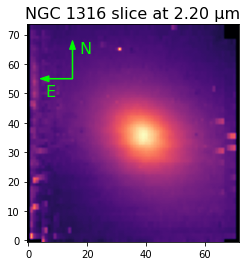

In [6]:
# Select one of 2218 slices
Slice = 1102       # integer between 0 and 2217 (prefer intermediate)
wvl = zaxis_to_wave(Slice)

###-------------- PLOT ----------------------###
plt.figsize=(15,13)
plt.title(f'NGC 1316 slice at {wvl:.2f} μm', fontsize = 16)
plt.imshow(Fornax_cube[Slice],origin = 'lower', cmap='magma',vmin=0 ) #, vmax =340)
#cbar = plt.colorbar()
plt.arrow(15, 55, 0, 10,head_width = 2,width = 0.2, color = 'lime')
plt.arrow(15, 55, -8, 0,head_width = 2,width = 0.2, color = 'lime')
plt.figtext(0.39, 0.78,'N', fontsize = 16, color ='lime')
plt.figtext(0.31, 0.63,'E', fontsize = 16, color ='lime')
#plt.xticks([])
#plt.yticks([])

#plt.savefig("NGC1316_slice.jpg", bbox_inches='tight')
plt.show()

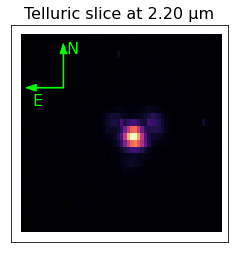

In [7]:
# Select one of 2218 slices
Slice = 1102       # integer between 0 and 2217 (prefer intermediate)
wvl = zaxis_to_wave(Slice)

###-------------- PLOT ----------------------###
plt.figsize=(15,13)
plt.title(f'Telluric slice at {wvl:.2f} μm', fontsize = 16)
plt.imshow(Telluric_cube[Slice],origin = 'lower', cmap='magma',vmin=0 ) #, vmax =340)
#cbar = plt.colorbar()
plt.arrow(15, 45, 0, 10,head_width = 2,width = 0.2, color = 'lime')
plt.arrow(15, 45, -8, 0,head_width = 2,width = 0.2, color = 'lime')
plt.figtext(0.39, 0.78,'N', fontsize = 16, color ='lime')
plt.figtext(0.31, 0.60,'E', fontsize = 16, color ='lime')
plt.xticks([])
plt.yticks([])

#plt.savefig("Telluric_slice.jpg",bbox_inches='tight')
plt.show()

# Show the NGC 1316 Spectrum of one pixel

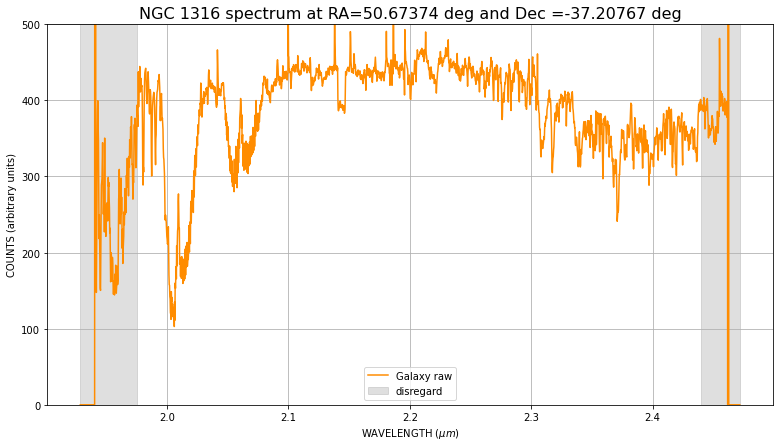

In [8]:
# Select one pixel by selecting coordinates
X_pixel =  45 # Select between 0 and 71
Y_pixel =  35 # Select between 0 and 73

RA_pixel = xaxis_to_ra(X_pixel)
Dec_pixel = yaxis_to_dec(X_pixel)

###-------------- PLOT ----------------------###
X_G = wl_axis
Y_G = Fornax_cube[:,Y_pixel,X_pixel]
plt.figure(figsize=(13, 7))
plt.title(f'NGC 1316 spectrum at RA={RA_pixel:.5f} deg and Dec ={Dec_pixel:.5f} deg' , fontsize = 16)
plt.plot(X_G,Y_G, color = 'darkorange', label = 'Galaxy raw')
plt.axvspan(X_G[0], 1.975, color='gray',alpha=0.25, label='disregard')   #area to disregard
plt.axvspan(2.44, X_G[-1], color='gray',alpha=0.25)   #area to disregard
plt.ylim([0, 500])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS (arbitrary units)')
plt.legend()
plt.grid()

# Show Integrated Telluric Spectrum

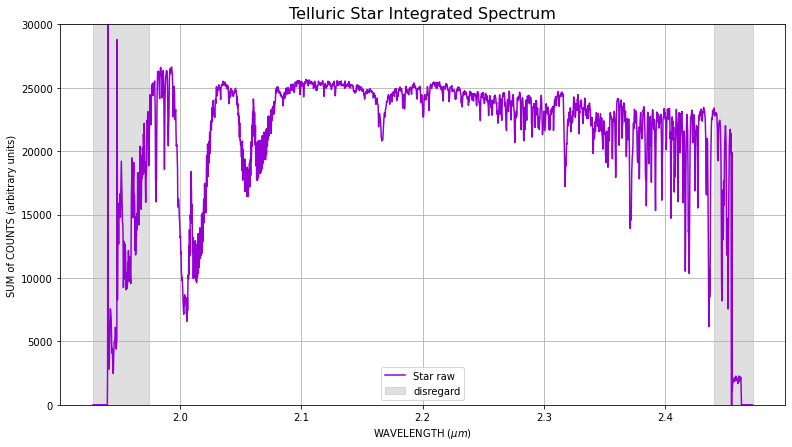

In [9]:
# Full integrated star spectrum
X_star =  df_star['Wavelength']
Y_star = df_star['Counts_Sum']

###-------------- PLOT ----------------------###
plt.figure(figsize=(13, 7))
plt.title('Telluric Star Integrated Spectrum', fontsize = 16)
plt.plot(X_star,Y_star, color = 'darkviolet', label = 'Star raw')
#plt.axvspan(2.155,2.18, color='violet', alpha=0.25, label='star absorption line')
plt.axvspan(wl_axis[0], 1.975, color='gray',alpha=0.25, label='disregard')   #area to disregard
plt.axvspan(2.44, wl_axis[-1], color='gray',alpha=0.25)   #area to disregard
plt.ylim([0, 30000])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('SUM of COUNTS (arbitrary units)')
plt.legend()
plt.grid()

# Step 0 : Trimming spectrum

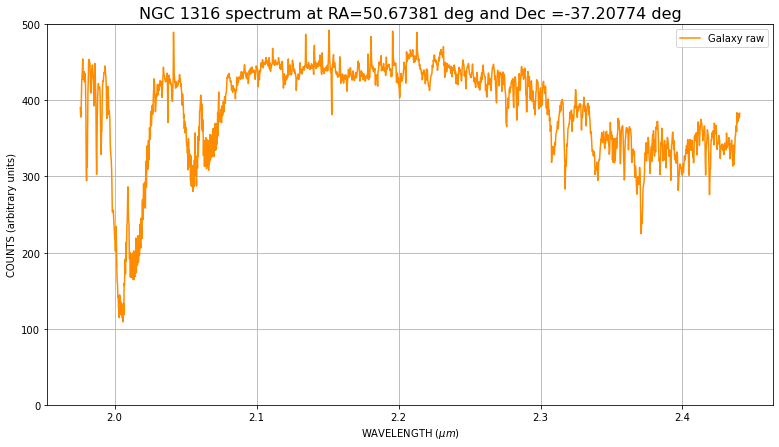

In [10]:
# Select one pixel by selecting coordinates
X_pixel =  40 # Select between 0 and 71
Y_pixel =  30 # Select between 0 and 73

RA_pixel = xaxis_to_ra(X_pixel)
Dec_pixel = yaxis_to_dec(X_pixel)

###-------------- PLOT ----------------------###
X_G = wl_axis[193:2090]
Y_G = Fornax_cube[193:2090,Y_pixel,X_pixel]
plt.figure(figsize=(13, 7))
plt.title(f'NGC 1316 spectrum at RA={RA_pixel:.5f} deg and Dec ={Dec_pixel:.5f} deg' , fontsize = 16)
plt.plot(X_G,Y_G, color = 'darkorange', label = 'Galaxy raw')
plt.ylim([0, 500])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS (arbitrary units)')
plt.legend()
plt.grid()

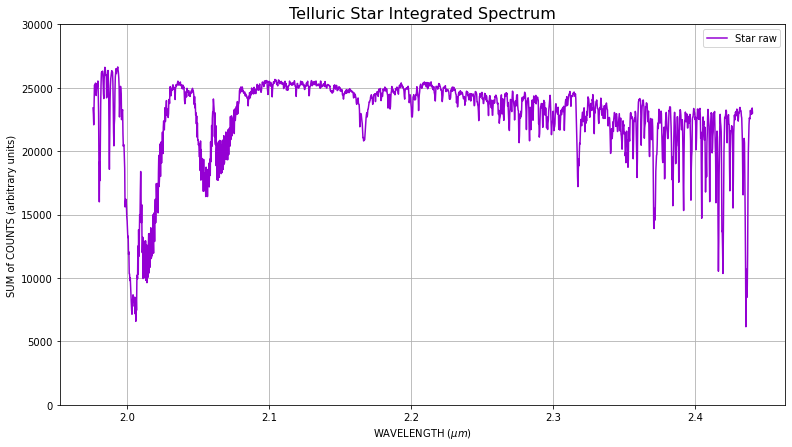

In [11]:
# Full integrated star spectrum
X_star =  df_star['Wavelength'][193:2090]
Y_star = df_star['Counts_Sum'][193:2090]

###-------------- PLOT ----------------------###
plt.figure(figsize=(13, 7))
plt.title('Telluric Star Integrated Spectrum', fontsize = 16)
plt.plot(X_star,Y_star, color = 'darkviolet', label = 'Star raw')
plt.ylim([0, 30000])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('SUM of COUNTS (arbitrary units)')
plt.legend()
plt.grid()

# Step 1: Telluric Normalisation with black body fit

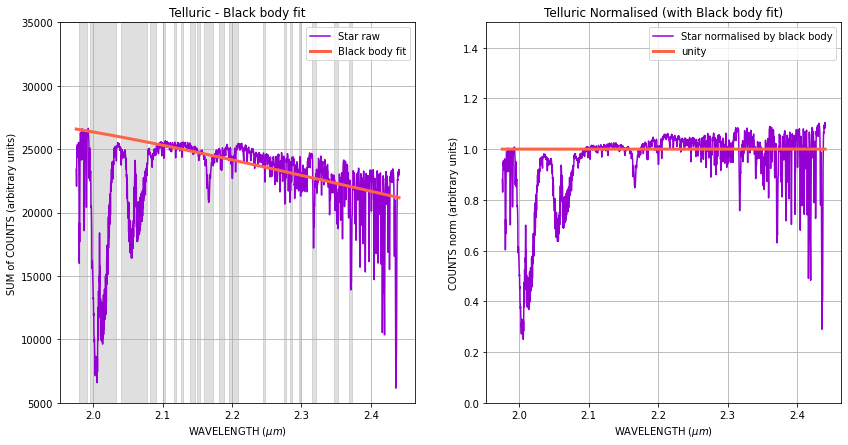

In [12]:
# Telluric Raw
X_star =  df_star['Wavelength'][193:2090]
Y_star = df_star['Counts_Sum'][193:2090]

##----------------  PLOT   ------------------##
plt.figure(figsize=(14, 7))

##----------------  SubPlot 1  ------------------##
plt.subplot(1, 2, 1)
plt.title('Telluric - Black body fit')
plt.plot(X_star,Y_star, color = 'darkviolet', label = 'Star raw')
mask_starlines=[[1.98,1.991], [1.995,2.033], [2.04,2.078], [2.082,2.09],
                [2.100,2.103], [2.117,2.120], [2.127,2.129], [2.14,2.147],
                [2.150,2.154], [2.16,2.172], [2.182,2.188], [2.195,2.209],
                [2.245,2.248], [2.275,2.278], [2.283,2.286], [2.296,2.2985], 
                [2.315,2.321], [2.347,2.352], [2.368,2.372]]
mm = np.ones(len(X_star),dtype=bool)
for m in mask_starlines:
    plt.axvspan(m[0],m[1],color="gray",alpha=0.25)
    mm[np.where((X_star>=m[0])&(X_star<=m[1]))]=False

popt, pcov = curve_fit(black_body, X_star[mm], Y_star[mm] )
h_best, C_best, kB_best  = popt
CONT_star_bb = black_body(X_star, h_best, C_best, kB_best) # το cont είναι όλα τα y του black body fit
plt.plot(X_star, CONT_star_bb, lw = 3, color = 'tomato', label = 'Black body fit')
plt.ylim([5000, 35000])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('SUM of COUNTS (arbitrary units)')
plt.legend()
plt.grid()

##----------------  SubPlot 2  ------------------##
plt.subplot(1, 2, 2)
plt.title('Telluric Normalised (with Black body fit)')
plt.plot(X_star,Y_star/CONT_star_bb, color = 'darkviolet', label = 'Star normalised by black body')
plt.plot(X_star, CONT_star_bb/CONT_star_bb, lw = 3, color = 'tomato', label = 'unity')
plt.ylim([0.0, 1.5])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS norm (arbitrary units)')
plt.legend()
plt.grid()

plt.show()

### Compact Plot

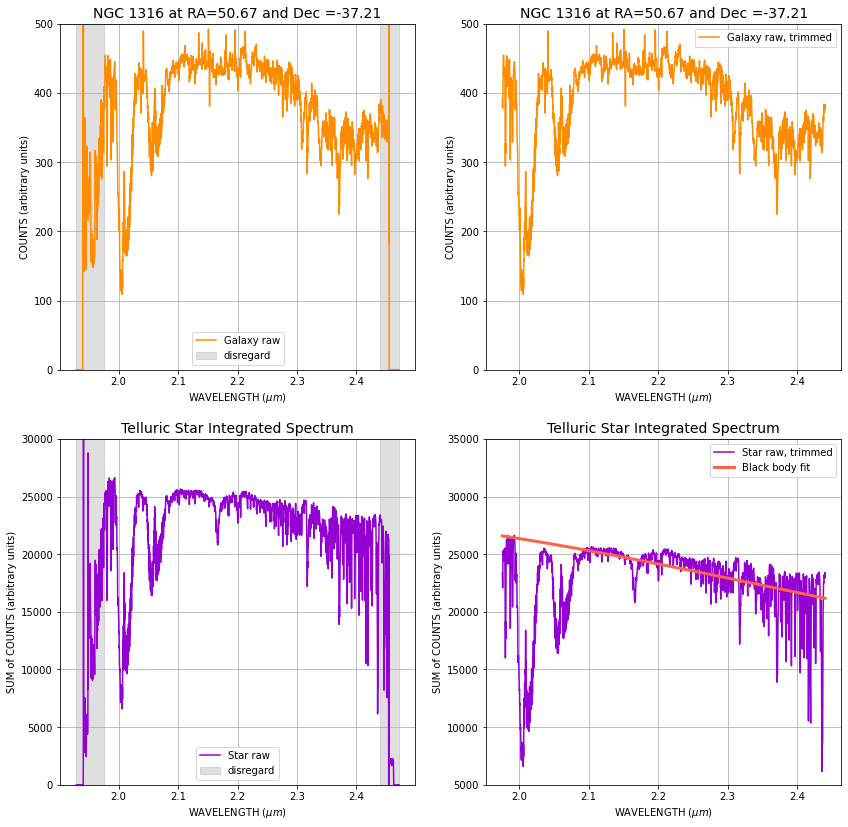

In [13]:
##----------------  PLOT   ------------------##
plt.figure(figsize=(14, 14))

##----------------  SubPlot 1  ------------------##
plt.subplot(2, 2, 1)
plt.title(f'NGC 1316 at RA={RA_pixel:.2f} and Dec ={Dec_pixel:.2f}' , fontsize = 14)
plt.plot(wl_axis,Fornax_cube[:,Y_pixel,X_pixel], color = 'darkorange', label = 'Galaxy raw')
plt.axvspan(wl_axis[0], 1.975, color='gray',alpha=0.25, label='disregard')   #area to disregard
plt.axvspan(2.44, wl_axis[-1], color='gray',alpha=0.25)   #area to disregard
plt.ylim([0, 500])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS (arbitrary units)')
plt.legend()
plt.grid()
##----------------  SubPlot 2  ------------------##
plt.subplot(2, 2, 2)
plt.title(f'NGC 1316 at RA={RA_pixel:.2f} and Dec ={Dec_pixel:.2f}' , fontsize = 14)
plt.plot(X_G,Y_G, color = 'darkorange', label = 'Galaxy raw, trimmed')
plt.ylim([0, 500])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS (arbitrary units)')
plt.legend()
plt.grid()

##----------------  SubPlot 3  ------------------##
plt.subplot(2, 2, 3)
plt.title('Telluric Star Integrated Spectrum', fontsize = 14)
plt.plot(df_star['Wavelength'],df_star['Counts_Sum'], color = 'darkviolet', label = 'Star raw')
plt.axvspan(wl_axis[0], 1.975, color='gray',alpha=0.25, label='disregard')   #area to disregard
plt.axvspan(2.44, wl_axis[-1], color='gray',alpha=0.25)   #area to disregard
plt.ylim([0, 30000])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('SUM of COUNTS (arbitrary units)')
plt.legend()
plt.grid()
##----------------  SubPlot 4  ------------------##
plt.subplot(2, 2, 4)
plt.title('Telluric Star Integrated Spectrum', fontsize = 14)
plt.plot(X_star,Y_star, color = 'darkviolet', label = 'Star raw, trimmed')
plt.plot(X_star, CONT_star_bb, lw = 3, color = 'tomato', label = 'Black body fit')
plt.ylim([5000, 35000])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('SUM of COUNTS (arbitrary units)')
plt.legend()
plt.grid()

plt.savefig("TrimmedSpectra.jpg",bbox_inches='tight')

# Step 2: Compare Telluric with template star to recognise lines

### Template Star normalisation

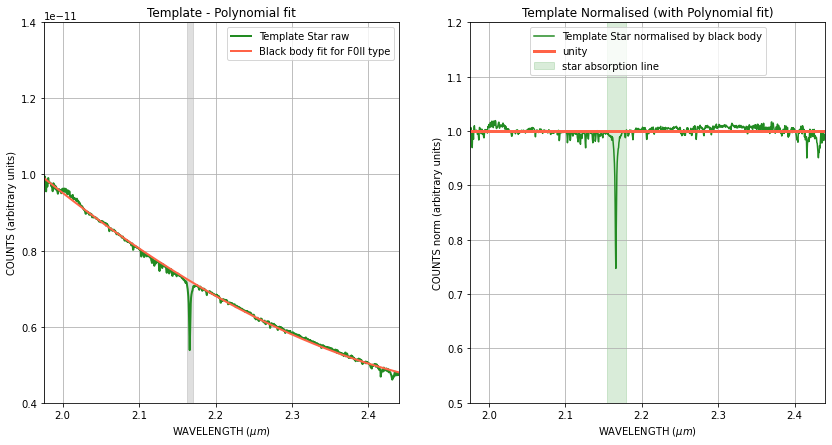

In [14]:
# Template raw
x_temp = Template_star[0]     
y_temp = Template_star[1]

##----------------  PLOT   ------------------##
plt.figure(figsize=(14, 7))

##----------------  SubPlot 1  ------------------##
plt.subplot(1, 2, 1)
plt.title('Template - Polynomial fit')
plt.plot(x_temp, y_temp, color='forestgreen', lw = 2, label = 'Template Star raw')
mask_F=[[x_temp[0],1.975], [2.162,2.17], [2.44, x_temp[-1] ] ]
mm_F = np.ones(len(x_temp),dtype=bool)
for m in mask_F:
    plt.axvspan(m[0],m[1],color="gray",alpha=0.25)
    mm_F[np.where((x_temp>=m[0])&(x_temp<=m[1]))]=False

ppF = np.polyfit(x_temp[mm_F],y_temp[mm_F],3)  #o αριθμός είναι ο βαθμός πολυωνύμου
CONTF_star_bb = np.poly1d(ppF)(x_temp)
plt.plot(x_temp, CONTF_star_bb, lw = 2, color = 'tomato', label = 'Black body fit for F0II type')
plt.xlim([X_G[0], X_G[-1] ])
plt.ylim([0.4e-11, 1.4e-11])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS (arbitrary units)')
plt.legend()
plt.grid()

##----------------  SubPlot 2  ------------------##
plt.subplot(1, 2, 2)
plt.title('Template Normalised (with Polynomial fit)')
plt.plot(x_temp, y_temp/CONTF_star_bb, color='forestgreen', label = 'Template Star normalised by black body')
plt.plot(x_temp, CONTF_star_bb/CONTF_star_bb, lw = 3, color = 'tomato', label = 'unity')
plt.axvspan(2.155,2.18, color='g', alpha=0.15, label='star absorption line')
plt.xlim([X_G[0], X_G[-1] ])
plt.ylim([0.5, 1.2])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS norm (arbitrary units)')
plt.legend(loc='upper center')
plt.grid()

plt.show()



### Compare Star Spectrum with template star to recognise lines

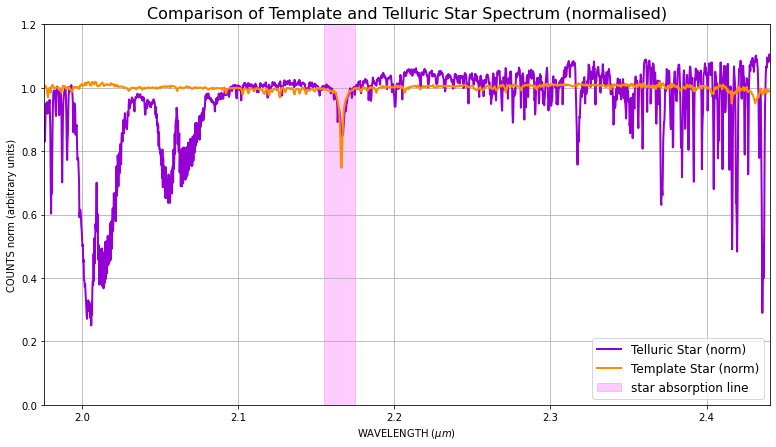

In [15]:
# Normalised Telluric
X_starN , Y_starN =  X_star , Y_star/CONT_star_bb

# Normalised Template
x_tempN , y_tempN  = x_temp, y_temp/CONTF_star_bb

###-------------- PLOT ----------------------###
plt.figure(figsize=(13, 7))
plt.title('Comparison of Template and Telluric Star Spectrum (normalised)', fontsize = 16)
plt.plot(X_starN,Y_starN, lw = 2, color = 'darkviolet', label = 'Telluric Star (norm)')
plt.plot(x_tempN , y_tempN, lw = 2, color = 'darkorange', label = 'Template Star (norm)')
plt.axvspan(2.155,2.175, color='magenta', alpha=0.2, label='star absorption line')
plt.xlim([X_G[0], X_G[-1] ])
plt.ylim([0, 1.2])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS norm (arbitrary units)')
plt.legend(loc='lower right', fontsize = 12)
plt.grid()



### Compact Plot






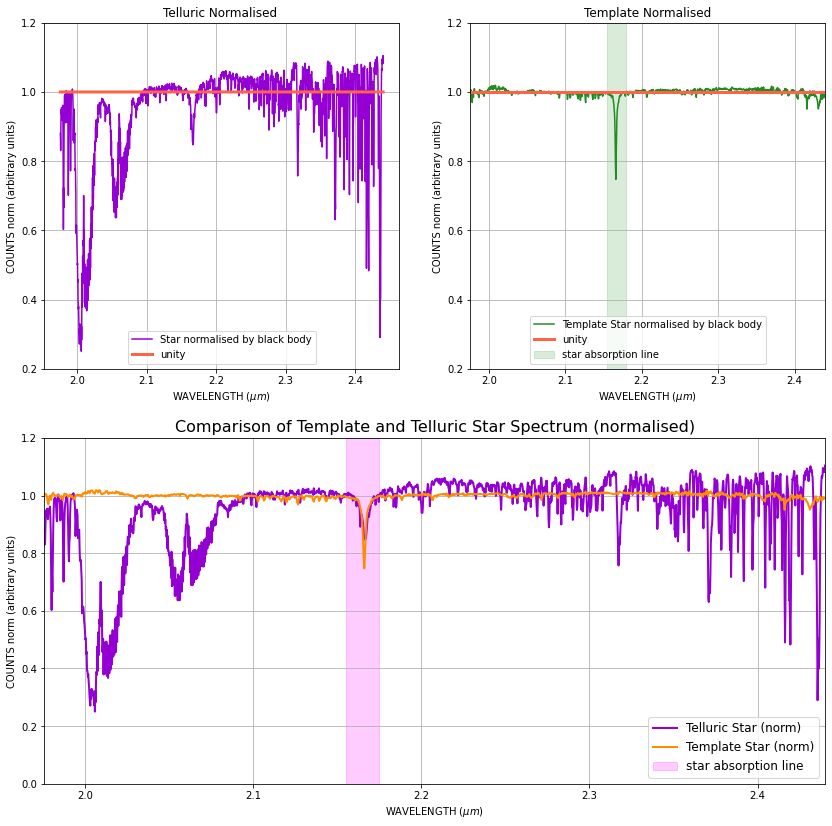

In [17]:
##----------------  PLOT   ------------------##
plt.figure(figsize=(14, 14))

##----------------  SubPlot 1  ------------------##
plt.subplot(2, 2, 1)
plt.title('Telluric Normalised ')
plt.plot(X_star,Y_star/CONT_star_bb, color = 'darkviolet', label = 'Star normalised by black body')
plt.plot(X_star, CONT_star_bb/CONT_star_bb, lw = 3, color = 'tomato', label = 'unity')
plt.ylim([0.2, 1.2])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS norm (arbitrary units)')
plt.legend(loc='lower center')
plt.grid()

##----------------  SubPlot 2  ------------------##
plt.subplot(2, 2, 2)
plt.title('Template Normalised')
plt.plot(x_temp, y_temp/CONTF_star_bb, color='forestgreen', label = 'Template Star normalised by black body')
plt.plot(x_temp, CONTF_star_bb/CONTF_star_bb, lw = 3, color = 'tomato', label = 'unity')
plt.axvspan(2.155,2.18, color='g', alpha=0.15, label='star absorption line')
plt.xlim([X_G[0], X_G[-1] ])
plt.ylim([0.2, 1.2])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS norm (arbitrary units)')
plt.legend(loc='lower center')
plt.grid()

##----------------  SubPlot 2  ------------------##
plt.subplot(2, 1, 2)
plt.title('Comparison of Template and Telluric Star Spectrum (normalised)', fontsize = 16)
plt.plot(X_starN,Y_starN, lw = 2, color = 'darkviolet', label = 'Telluric Star (norm)')
plt.plot(x_tempN , y_tempN, lw = 2, color = 'darkorange', label = 'Template Star (norm)')
plt.axvspan(2.155,2.175, color='magenta', alpha=0.2, label='star absorption line')
plt.xlim([X_G[0], X_G[-1] ])
plt.ylim([0, 1.2])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS norm (arbitrary units)')
plt.legend(loc='lower right', fontsize = 12)
plt.grid()

#plt.savefig("Tellu&Templ_spectrum.jpg",bbox_inches='tight')

# Step 3: Remove the prominent star line from (norm) Telluric

The result should be the normalised atmosphere absorption spectrum

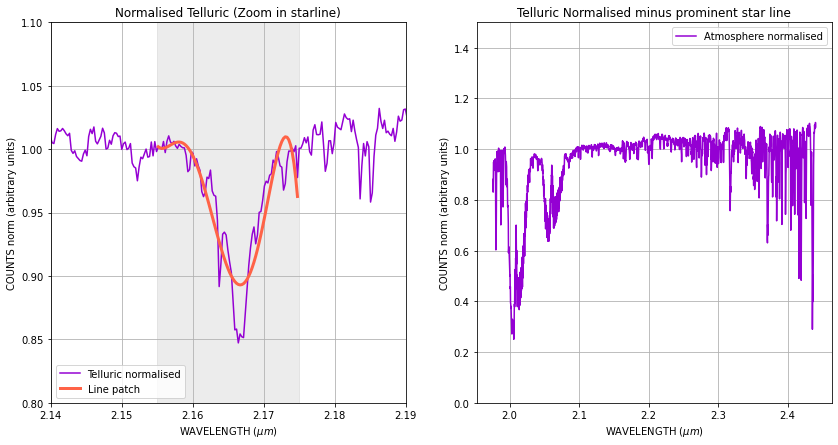

In [18]:
# Normalised Telluric
X_starN , Y_starN =  X_star , Y_star/CONT_star_bb

##----------------  PLOT   ------------------##
plt.figure(figsize=(14, 7))

##----------------  SubPlot 1  ------------------##
plt.subplot(1, 2, 1)
plt.title('Normalised Telluric (Zoom in starline)')
plt.plot(X_starN,Y_starN, color = 'darkviolet', label = 'Telluric normalised')
mask_absline=[2.155,2.175]
mm = np.zeros(len(X_starN),dtype=bool)  #This is a mask of Falses
mm[np.where((X_starN>=mask_absline[0])&(X_starN<=mask_absline[1]))]=True  #with the exception of this range
pp_s = np.polyfit(X_starN[mm],Y_starN[mm],10)  #4 order polynomial fit only for this window
Line_patch = np.poly1d(pp_s)(X_starN[mm])
plt.plot(X_starN[mm], Line_patch, lw = 3, color = 'tomato', label = 'Line patch')
plt.axvspan(2.155,2.175, color='gray',alpha=0.15)   #area to disregard
plt.ylim([0.8, 1.1])
plt.xlim([2.14,2.19])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS norm (arbitrary units)')
plt.legend(loc='lower left')
plt.grid()

##----------------  SubPlot 2  ------------------##
Y_N_atmo = np.copy(Y_starN)
Y_N_atmo[mm] = Y_N_atmo[mm]/Line_patch

plt.subplot(1, 2, 2)
plt.title('Telluric Normalised minus prominent star line')
plt.plot(X_starN , Y_N_atmo, color = 'darkviolet', label = 'Atmosphere normalised')
plt.ylim([0.0, 1.5])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS norm (arbitrary units)')
plt.legend()
plt.grid()

plt.show()


# Step 4: Further corrections for Atmosphere: exponential correction


In [19]:
# Atmosphere Normalised (by telluric black body)
X_atmoN = X_star
Y_atmoN = Y_N_atmo

# Atmosphere normalised with exponential correction
X_atmoNE = X_star
exponent = 0.9
Y_atmoNE = Y_atmoN**(exponent)


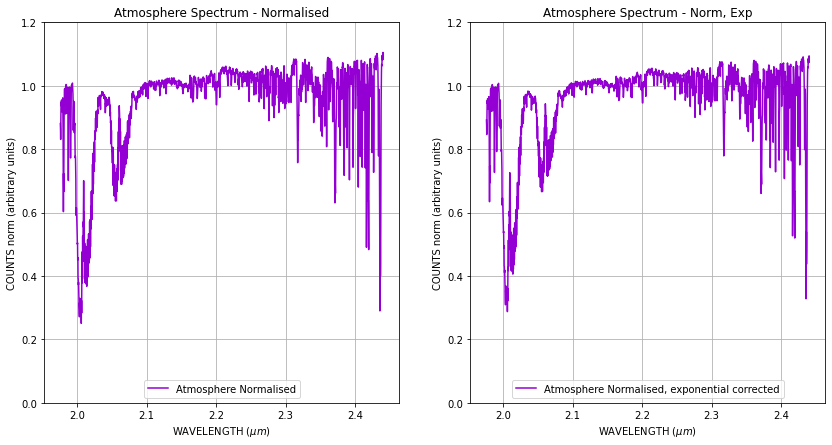

In [20]:
## ------------ PLOT ------------------ ##
plt.figure(figsize=(14, 7))

##----------------  SubPlot 1  ------------------##
plt.subplot(1, 2, 1)
plt.title('Atmosphere Spectrum - Normalised')
plt.plot(X_atmoN,Y_atmoN, color = 'darkviolet', label='Atmosphere Normalised')
plt.ylim([0, 1.2])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS norm (arbitrary units)')
plt.legend(loc ='lower center')
plt.grid()
##----------------  SubPlot 2  ------------------##
plt.subplot(1, 2, 2)
plt.title('Atmosphere Spectrum - Norm, Exp')
plt.plot(X_atmoNE,Y_atmoNE, color = 'darkviolet', label='Atmosphere Normalised, exponential corrected')
plt.ylim([0, 1.2])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS norm (arbitrary units)')
plt.legend(loc ='lower center')
plt.grid()


plt.show()

# Step 5: Atmospheric removal from Galaxy 


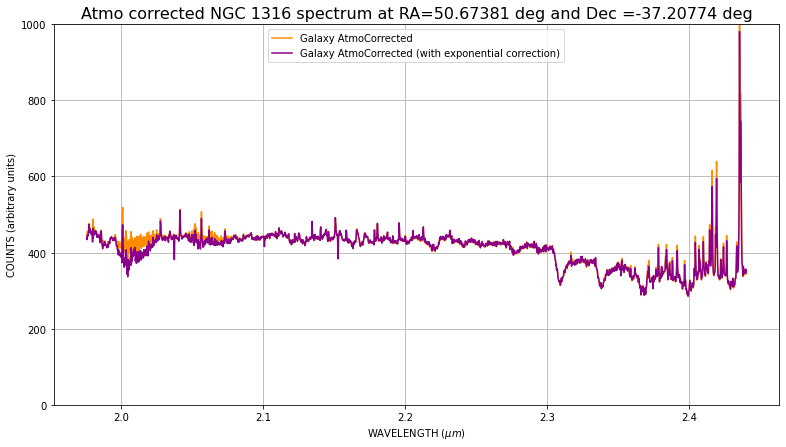

In [21]:
# Dividing Galaxy spectrum with normalised, smoothed (and try exponentially corrected) atmosphere
# resulting to atmosphere correction and full galaxy signal

# Select one pixel by selecting coordinates
X_pixel =  40 # Select between 0 and 71
Y_pixel =  30 # Select between 0 and 73

RA_pixel = xaxis_to_ra(X_pixel)
Dec_pixel = yaxis_to_dec(X_pixel)

###-------------- PLOT ----------------------###
X_G = wl_axis[193:2090]
Y_G = Fornax_cube[:,Y_pixel,X_pixel][193:2090]
Y_G_N = Y_G/Y_atmoN
Y_G_NE = Y_G/Y_atmoNE

plt.figure(figsize=(13, 7))
plt.title(f'Atmo corrected NGC 1316 spectrum at RA={RA_pixel:.5f} deg and Dec ={Dec_pixel:.5f} deg' , fontsize = 16)
plt.plot(X_G,Y_G_N, color = 'darkorange', label = 'Galaxy AtmoCorrected ')
plt.plot(X_G,Y_G_NE, color = 'darkmagenta', label = 'Galaxy AtmoCorrected (with exponential correction)')
plt.ylim([0, 1000])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS (arbitrary units)')
plt.legend(loc ='upper center')
plt.grid()

The atmospheric abrosption is significantly reduced from the galaxy spectrum

### Compact Plot

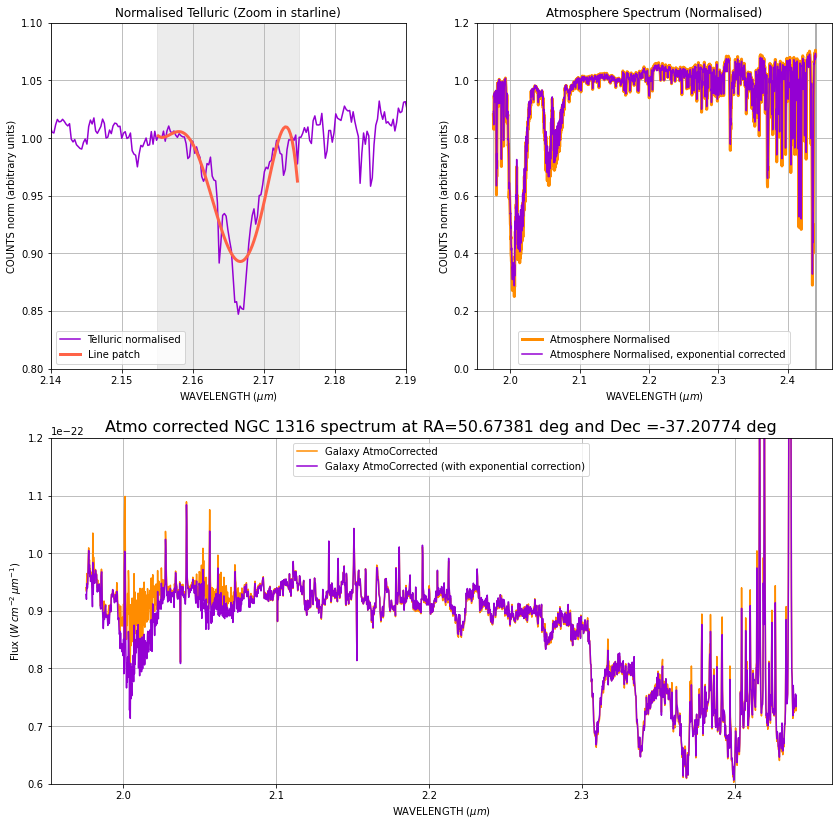

In [22]:
## ------------ PLOT ------------------ ##
plt.figure(figsize=(14,14))

##----------------  SubPlot 1  ------------------##
plt.subplot(2, 2, 1)
plt.title('Normalised Telluric (Zoom in starline)')
plt.plot(X_starN,Y_starN, color = 'darkviolet', label = 'Telluric normalised')
mask_absline=[2.155,2.175]
mm = np.zeros(len(X_starN),dtype=bool)  #This is a mask of Falses
mm[np.where((X_starN>=mask_absline[0])&(X_starN<=mask_absline[1]))]=True  #with the exception of this range
pp_s = np.polyfit(X_starN[mm],Y_starN[mm],10)  #4 order polynomial fit only for this window
Line_patch = np.poly1d(pp_s)(X_starN[mm])
plt.plot(X_starN[mm], Line_patch, lw = 3, color = 'tomato', label = 'Line patch')
plt.axvspan(2.155,2.175, color='gray',alpha=0.15)   #area to disregard
plt.ylim([0.8, 1.1])
plt.xlim([2.14,2.19])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS norm (arbitrary units)')
plt.legend(loc='lower left')
plt.grid()
##----------------  SubPlot 2  ------------------##
plt.subplot(2, 2, 2)
plt.title('Atmosphere Spectrum (Normalised)')
plt.plot(X_atmoN,Y_atmoN,lw = 3, color='darkorange', label='Atmosphere Normalised')
plt.plot(X_atmoNE,Y_atmoNE, color='darkviolet', label='Atmosphere Normalised, exponential corrected')
plt.ylim([0, 1.2])
plt.axvspan(X_G[0], 1.975, color='gray',alpha=0.5)   #area to disregard
plt.axvspan(2.44, X_G[-1], color='gray',alpha=0.5)   #area to disregard
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('COUNTS norm (arbitrary units)')
plt.legend(loc ='lower center')
plt.grid()
##----------------  SubPlot 3  ------------------##
plt.subplot(2, 1, 2)
plt.title(f'Atmo corrected NGC 1316 spectrum at RA={RA_pixel:.5f} deg and Dec ={Dec_pixel:.5f} deg' , fontsize = 16)
plt.plot(X_G,Y_G_N*2.1199047542865678e-25, color = 'darkorange', label = 'Galaxy AtmoCorrected ')
plt.plot(X_G,Y_G_NE*2.1199047542865678e-25, color = 'darkviolet', label = 'Galaxy AtmoCorrected (with exponential correction)')
plt.ylim([0.6e-22, 1.2e-22])
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('Flux ($W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc ='upper center')
plt.grid()

#plt.savefig("ATMO_Tellu_RemoveLine.jpg",bbox_inches='tight')
plt.show()

# Step 6: Flux calibration

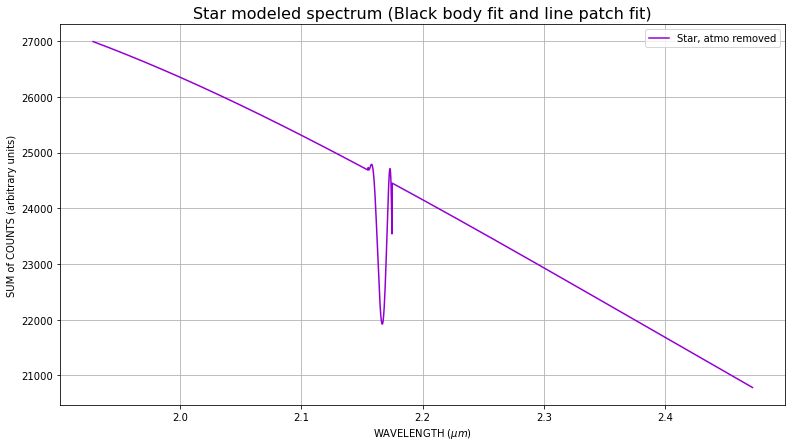

In [23]:
# Atmosphere removed star spectrum (not normalised)
# Calculated in full K band range (before trimming)
X_star0 =  df_star['Wavelength']
Y_star0 = black_body(X_star0, h_best, C_best, kB_best)
mask_absline=[2.155,2.175]
mm = np.zeros(len(X_star0),dtype=bool)  #This is a mask of Falses
mm[np.where((X_star0>=mask_absline[0])&(X_star0<=mask_absline[1]))]=True  #with the exception of this range
Line_patch0 = np.poly1d(pp_s)(X_star0[mm])
Y_star0[mm] = Y_star0[mm]*Line_patch0

###-------------- PLOT ----------------------###
plt.figure(figsize=(13, 7))
plt.title('Star modeled spectrum (Black body fit and line patch fit)', fontsize = 16)
plt.plot(X_star0,Y_star0, color = 'darkviolet', label = 'Star, atmo removed')
plt.xlabel('WAVELENGTH ($\mu m$)')
plt.ylabel('SUM of COUNTS (arbitrary units)')
plt.legend()
plt.grid()


In [24]:
TotalFlux = 1.13e-17 #W/cm^2/μm   (from 2MASS survey)
IntegralCounts = np.sum(Y_star0)

Flux_per_count = TotalFlux/IntegralCounts   # Calibration of y spectral axis

print('Flux units per Count : ',Flux_per_count, 'W/cm/cm/micron' )

Flux units per Count :  2.1199047542865678e-25 W/cm/cm/micron


# Step 7: $H_2$ lines

In [25]:
from scipy.constants import h,k

s0_emission = 2.2235    # 1-0 S(0)
s1_emission = 2.1218    # 1-0 S(1)
s2_emission = 2.0338    # 1-0 S(2)

s0 = (1+z_gal)*s0_emission    # redshifted
s1 = (1+z_gal)*s1_emission    # redshifted
s2 = (1+z_gal)*s2_emission    # redshifted

g_s0 = 5.0
g_s1 = 21.0
g_s2 = 9.0

T_s0 = 6471  #in K
T_s1 = 6956  #in K
T_s2 = 7584  #in K

A_s0 = 2.53  #in e-7 einstein coefficient
A_s1 = 3.47
A_s2 = 3.98

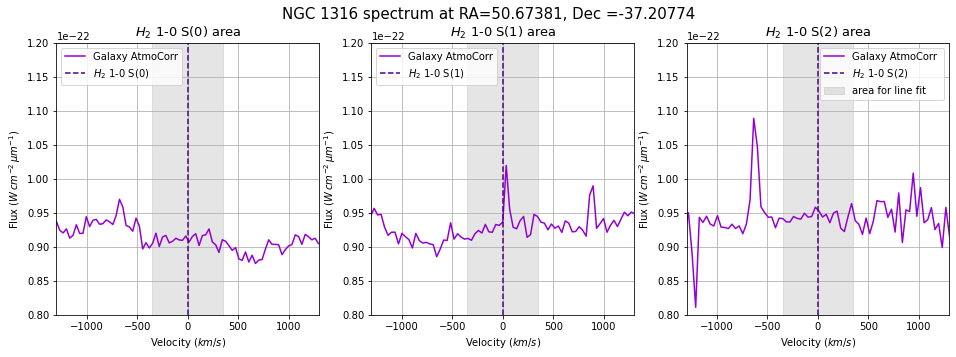

In [26]:
XX = np.copy(X_G)
YY_GN = Y_G_N*Flux_per_count
YY_GNE = Y_G_NE*Flux_per_count

X_s0 = wvl_to_vel(s0, XX)
X_s1 = wvl_to_vel(s1, XX)
X_s2 = wvl_to_vel(s2, XX)


## ------------ PLOT ------------------ ##
plt.figure(figsize=(16,5))
plt.suptitle(f'NGC 1316 spectrum at RA={RA_pixel:.5f}, Dec ={Dec_pixel:.5f}', fontsize = 15)
             
##----------------  SubPlot 1  ------------------##
plt.subplot(1, 3, 1)
plt.title('$H_2$ 1-0 S(0) area', fontsize = 13)      
plt.plot(X_s0,YY_GN, color = 'darkviolet', label = 'Galaxy AtmoCorr')
#plt.plot(X_s0,YY_GNE, color = 'darkviolet', label = 'Galaxy AtmoCorrected (with exponential correction)')
plt.axvline(s0, ls='--', color = 'indigo', label='$H_2$ 1-0 S(0)')
plt.axvspan(-350,350, color='gray',alpha=0.2)
plt.ylim([0.8e-22, 1.2e-22])
#plt.ylim([0.4e-22, 0.6e-22])
plt.xlim([-1300,1300])
plt.xlabel('Velocity ($ km / s$)')
plt.ylabel('Flux ($W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper left')
plt.grid()
##----------------  SubPlot 2  ------------------##
plt.subplot(1, 3, 2)
plt.title('$H_2$ 1-0 S(1) area', fontsize = 13) 
plt.plot(X_s1,YY_GN, color = 'darkviolet', label = 'Galaxy AtmoCorr')
#plt.plot(X_s1,YY_GNE, color = 'darkviolet', label = 'Galaxy AtmoCorrected (with exponential correction)')
plt.axvline(s1, ls='--',color = 'indigo', label='$H_2$ 1-0 S(1)')
#plt.plot(X_s1fit[mm_s1],Gauss_s1 , color = 'tomato', label = 'Voigt fit ')
plt.axvspan(-350,350, color='gray',alpha=0.2)
plt.ylim([0.8e-22, 1.2e-22])
#plt.ylim([0.4e-22, 0.6e-22])
plt.xlim([-1300,1300])
plt.xlabel('Velocity ($ km / s$)')
plt.ylabel('Flux ($W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper left')
plt.grid()
##----------------  SubPlot 3  ------------------##
plt.subplot(1, 3, 3)
plt.title('$H_2$ 1-0 S(2) area', fontsize = 13)
plt.plot(X_s2,YY_GN, color = 'darkviolet', label = 'Galaxy AtmoCorr ')
#plt.plot(X_s2,YY_GNE, color = 'darkviolet', label = 'Galaxy AtmoCorrected (with exponential correction)')
plt.axvline(s2, ls='--',color = 'indigo', label='$H_2$ 1-0 S(2)')
plt.axvspan(-350,350, color='gray',alpha=0.2, label ='area for line fit')
plt.ylim([0.8e-22, 1.2e-22])
#plt.ylim([0.4e-22, 0.6e-22])
plt.xlim([-1300,1300])
plt.xlabel('Velocity ($ km / s$)')
plt.ylabel('Flux ($W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper right')
plt.grid()

#plt.savefig("H2Lines4.jpg",bbox_inches='tight')
plt.show()

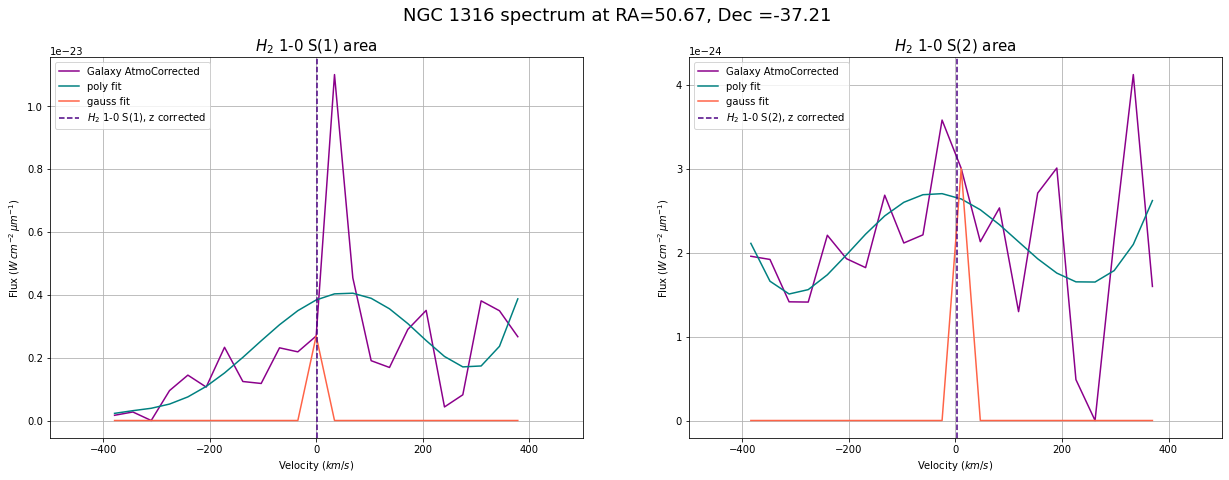

In [27]:
# Only care for lines s1 and s2
X_s1fit = np.copy(X_s1)   
X_s2fit = np.copy(X_s2)  

mask_linerange = [-400,400]
mm_s1 = np.zeros(len(X_s1fit),dtype=bool) 
mm_s1[np.where((X_s1fit>=mask_linerange[0])&(X_s1fit<=mask_linerange[1]))]=True  
mm_s2 = np.zeros(len(X_s1fit),dtype=bool) 
mm_s2[np.where((X_s2fit>=mask_linerange[0])&(X_s2fit<=mask_linerange[1]))]=True  

pp_s1 = np.polyfit(X_s1fit[mm_s1], YY_GN[mm_s1]-np.min(YY_GN[mm_s1]) ,5)  
pp_s2 = np.polyfit(X_s2fit[mm_s2], YY_GN[mm_s2]-np.min(YY_GN[mm_s2]) ,5)

popt_s1, pcov_s1 = curve_fit(gaussian, X_s1fit[mm_s1], YY_GN[mm_s1] - np.min(YY_GN[mm_s1]) )
A_best1, x0_best1, sigma_best1 = popt_s1
Gauss_s1 = gaussian(X_s1fit[mm_s1],  A_best1, x0_best1, sigma_best1)
popt_s2, pcov_s2 = curve_fit(gaussian, X_s2fit[mm_s2], YY_GN[mm_s2] - np.min(YY_GN[mm_s2]) )
A_best2, x0_best2, sigma_best2 = popt_s2
Gauss_s2 = gaussian(X_s2fit[mm_s2],  A_best2, x0_best2, sigma_best2)

## ------------ PLOT ------------------ ##
plt.figure(figsize=(21,7))
plt.suptitle(f'NGC 1316 spectrum at RA={RA_pixel:.2f}, Dec ={Dec_pixel:.2f}', fontsize = 18)
             
##----------------  SubPlot 1  -----------------##
plt.subplot(1, 2, 1)
plt.title('$H_2$ 1-0 S(1) area', fontsize = 15) 
plt.plot(X_s1fit[mm_s1],YY_GN[mm_s1] - np.min(YY_GN[mm_s1]), color = 'darkmagenta', label = 'Galaxy AtmoCorrected ')
plt.plot(X_s1fit[mm_s1],np.poly1d(pp_s1)(X_s1fit[mm_s1]), color = 'teal', label = 'poly fit ')
plt.plot(X_s1fit[mm_s1],Gauss_s1 , color = 'tomato', label = 'gauss fit ')
plt.axvline(s1, ls='--',color = 'indigo', label='$H_2$ 1-0 S(1), z corrected')
#plt.axvspan(-500,500, color='gray',alpha=0.2, label ='area for line fit')
#plt.ylim([1.5e-21, 2.5e-21])
plt.xlim([-500,500])
plt.xlabel('Velocity ($ km / s$)')
plt.ylabel('Flux ($W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper left')
plt.grid()
##----------------  SubPlot 3  ------------------##
plt.subplot(1, 2, 2)
plt.title('$H_2$ 1-0 S(2) area', fontsize = 15)
plt.plot(X_s2fit[mm_s2],YY_GN[mm_s2] - np.min(YY_GN[mm_s2]), color = 'darkmagenta', label = 'Galaxy AtmoCorrected ')
plt.plot(X_s2fit[mm_s2],np.poly1d(pp_s2)(X_s2fit[mm_s2]), color = 'teal', label = 'poly fit ')
plt.plot(X_s2fit[mm_s2],Gauss_s2 , color = 'tomato', label = 'gauss fit ')
plt.axvline(s2, ls='--',color = 'indigo', label='$H_2$ 1-0 S(2), z corrected')
#plt.axvspan(-450,250, color='gray',alpha=0.2, label ='area for line fit')
#plt.ylim([1.5e-21, 2.5e-21])
plt.xlim([-500,500])
plt.xlabel('Velocity ($ km / s$)')
plt.ylabel('Flux ($W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper left')
plt.grid()

#plt.savefig("H2Lines_fitZoom.jpg",bbox_inches='tight')
plt.show()

### Compact plot

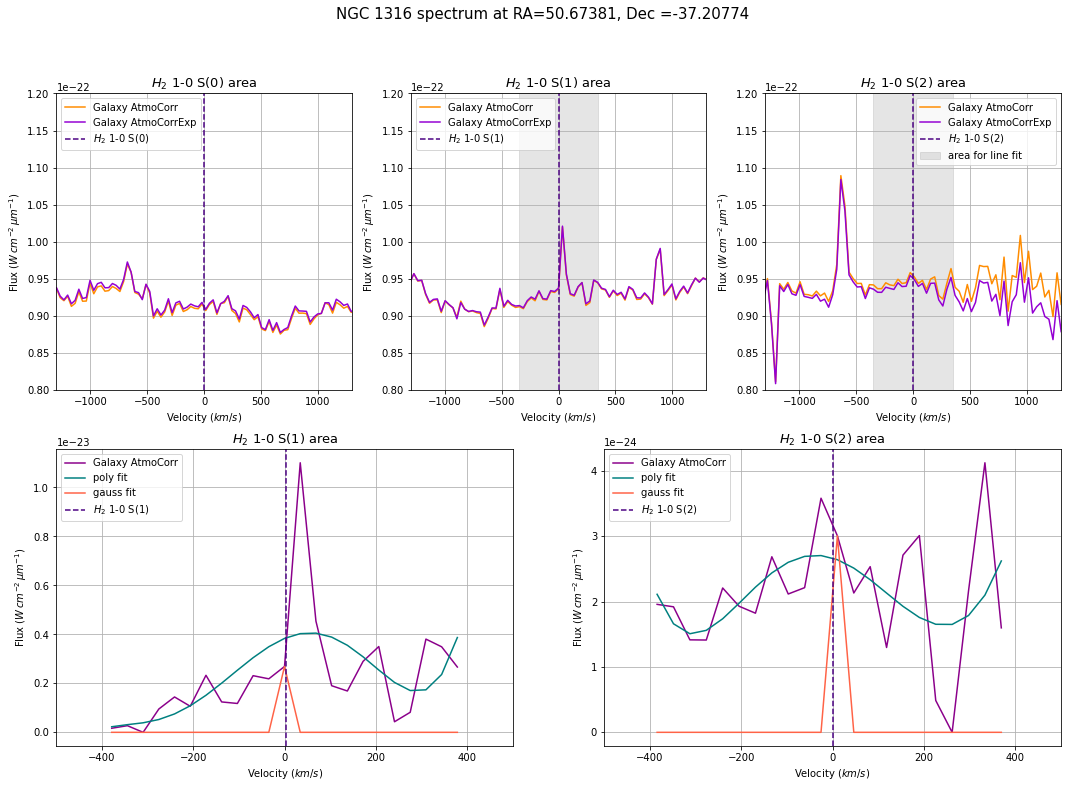

In [28]:
## ------------ PLOT ------------------ ##
plt.figure(figsize=(18,12))
plt.suptitle(f'NGC 1316 spectrum at RA={RA_pixel:.5f}, Dec ={Dec_pixel:.5f}', fontsize = 15)
             
##----------------  SubPlot 1  ------------------##
plt.subplot(2, 3, 1)
plt.title('$H_2$ 1-0 S(0) area', fontsize = 13)      
plt.plot(X_s0,YY_GN, color = 'darkorange', label = 'Galaxy AtmoCorr ')
plt.plot(X_s0,YY_GNE, color = 'darkviolet', label = 'Galaxy AtmoCorrExp')
plt.axvline(s0, ls='--', color = 'indigo', label='$H_2$ 1-0 S(0)')
plt.ylim([0.8e-22, 1.2e-22])
plt.xlim([-1300,1300])
plt.xlabel('Velocity ($ km / s$)')
plt.ylabel('Flux ($W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper left')
plt.grid()
##----------------  SubPlot 2  ------------------##
plt.subplot(2, 3, 2)
plt.title('$H_2$ 1-0 S(1) area', fontsize = 13) 
plt.plot(X_s1,YY_GN, color = 'darkorange', label = 'Galaxy AtmoCorr')
plt.plot(X_s1,YY_GNE, color = 'darkviolet', label = 'Galaxy AtmoCorrExp')
plt.axvline(s1, ls='--',color = 'indigo', label='$H_2$ 1-0 S(1)')
#plt.plot(X_s1fit[mm_s1],Gauss_s1 , color = 'tomato', label = 'Voigt fit ')
plt.axvspan(-350,350, color='gray',alpha=0.2)
plt.ylim([0.8e-22, 1.2e-22])
plt.xlim([-1300,1300])
plt.xlabel('Velocity ($ km / s$)')
plt.ylabel('Flux ($W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper left')
plt.grid()
##----------------  SubPlot 3  ------------------##
plt.subplot(2, 3, 3)
plt.title('$H_2$ 1-0 S(2) area', fontsize = 13)
plt.plot(X_s2,YY_GN, color = 'darkorange', label = 'Galaxy AtmoCorr')
plt.plot(X_s2,YY_GNE, color = 'darkviolet', label = 'Galaxy AtmoCorrExp')
plt.axvline(s2, ls='--',color = 'indigo', label='$H_2$ 1-0 S(2)')
plt.axvspan(-350,350, color='gray',alpha=0.2, label ='area for line fit')
plt.ylim([0.8e-22, 1.2e-22])
plt.xlim([-1300,1300])
plt.xlabel('Velocity ($ km / s$)')
plt.ylabel('Flux ($W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper right')
plt.grid()

##----------------  SubPlot 1  -----------------##
plt.subplot(2, 2, 3)
plt.title('$H_2$ 1-0 S(1) area', fontsize = 13) 
plt.plot(X_s1fit[mm_s1],YY_GN[mm_s1] - np.min(YY_GN[mm_s1]), color = 'darkmagenta', label = 'Galaxy AtmoCorr')
plt.plot(X_s1fit[mm_s1],np.poly1d(pp_s1)(X_s1fit[mm_s1]), color = 'teal', label = 'poly fit ')
plt.plot(X_s1fit[mm_s1],Gauss_s1 , color = 'tomato', label = 'gauss fit ')
plt.axvline(s1, ls='--',color = 'indigo', label='$H_2$ 1-0 S(1)')
#plt.axvspan(-500,500, color='gray',alpha=0.2, label ='area for line fit')
#plt.ylim([1.5e-21, 2.5e-21])
plt.xlim([-500,500])
plt.xlabel('Velocity ($ km / s$)')
plt.ylabel('Flux ($W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper left')
plt.grid()
##----------------  SubPlot 3  ------------------##
plt.subplot(2, 2, 4)
plt.title('$H_2$ 1-0 S(2) area', fontsize = 13)
plt.plot(X_s2fit[mm_s2],YY_GN[mm_s2] - np.min(YY_GN[mm_s2]), color = 'darkmagenta', label = 'Galaxy AtmoCorr')
plt.plot(X_s2fit[mm_s2],np.poly1d(pp_s2)(X_s2fit[mm_s2]), color = 'teal', label = 'poly fit ')
plt.plot(X_s2fit[mm_s2],Gauss_s2 , color = 'tomato', label = 'gauss fit ')
plt.axvline(s2, ls='--',color = 'indigo', label='$H_2$ 1-0 S(2)')
#plt.axvspan(-450,250, color='gray',alpha=0.2, label ='area for line fit')
#plt.ylim([1.5e-21, 2.5e-21])
plt.xlim([-500,500])
plt.xlabel('Velocity ($ km / s$)')
plt.ylabel('Flux ($W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper left')
plt.grid()

plt.savefig("H2Lines.jpg",bbox_inches='tight')
#plt.show()

NOT GOOD ENOUGH!!!!!!!!!!!!



# Let's do the integrated galaxy spectrum

In [29]:
X_gal = df_G['Wavelength'][193:2090]   #im microns
Y_gal0 = df_G['Counts_Sum'][193:2090]  
Y_gal = (Y_gal0/Y_atmoN) *Flux_per_count*1e19  # into e-19 W/cm^2/μm  AND atmocorrected


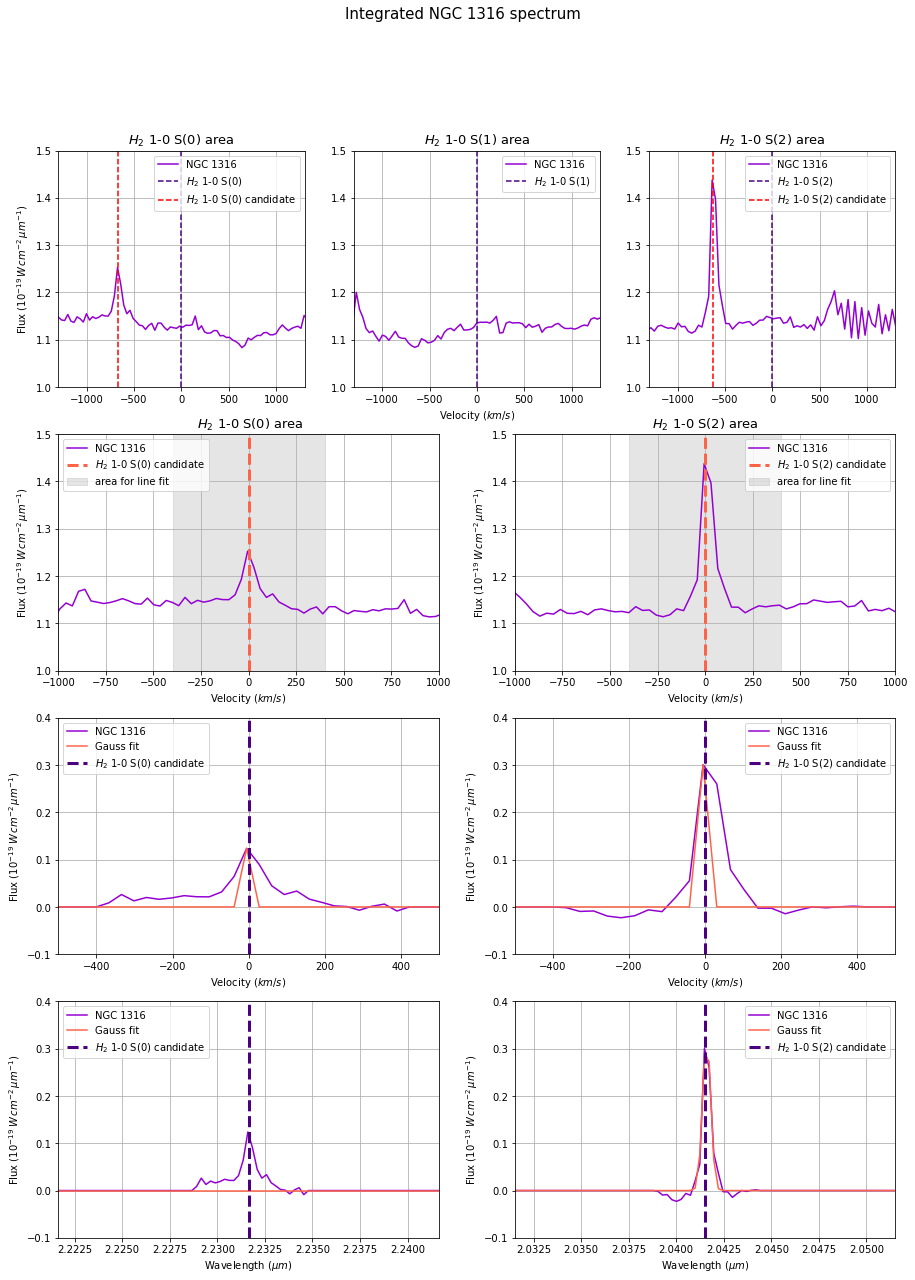

In [48]:
X_s0G = wvl_to_vel(s0, X_gal)
X_s1G = wvl_to_vel(s1, X_gal)
X_s2G = wvl_to_vel(s2, X_gal)

X_s0Gsh = wvl_to_vel(s0-0.005, X_gal)
X_s2Gsh = wvl_to_vel(s2-0.0043, X_gal)

## ------------ PLOT ------------------ ##
plt.figure(figsize=(15,20))
plt.suptitle(f'Integrated NGC 1316 spectrum', fontsize = 15)
             
##----------------  SubPlot 1  ------------------##
plt.subplot(4, 3, 1)
plt.title('$H_2$ 1-0 S(0) area', fontsize = 13)      
plt.plot(X_s0G,Y_gal, color = 'darkviolet', label = 'NGC 1316')
plt.axvline(0, ls='--', color = 'indigo', label='$H_2$ 1-0 S(0)')
plt.axvline(-670, ls='--', color = 'r', label='$H_2$ 1-0 S(0) candidate')
plt.ylim([1, 1.5])
plt.xlim([-1300,1300])
#plt.xlabel('Velocity ($ km / s$)')
plt.ylabel('Flux ($10^{-19}\,W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper right')
plt.grid()
##----------------  SubPlot 2  ------------------##
plt.subplot(4, 3, 2)
plt.title('$H_2$ 1-0 S(1) area', fontsize = 13) 
plt.plot(X_s1G,Y_gal, color = 'darkviolet', label = 'NGC 1316')
plt.axvline(0, ls='--',color = 'indigo', label='$H_2$ 1-0 S(1)')
plt.ylim([1, 1.5])
plt.xlim([-1300,1300])
plt.xlabel('Velocity ($ km / s$)')
#plt.ylabel('Flux ($W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper right')
plt.grid()
##----------------  SubPlot 3  ------------------##
plt.subplot(4, 3, 3)
plt.title('$H_2$ 1-0 S(2) area', fontsize = 13)
plt.plot(X_s2G,Y_gal, color = 'darkviolet', label = 'NGC 1316 ')
plt.axvline(0, ls='--',color = 'indigo', label='$H_2$ 1-0 S(2)')
plt.axvline(-630, ls='--',color = 'r', label='$H_2$ 1-0 S(2) candidate')
plt.ylim([1, 1.5])
plt.xlim([-1300,1300])
#plt.xlabel('Velocity ($ km / s$)')
#plt.ylabel('Flux ($W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper right')
plt.grid()

##----------------  SubPlot 4  ------------------##
plt.subplot(4, 2, 3)
plt.title('\n $H_2$ 1-0 S(0) area', fontsize = 13) 
plt.plot(X_s0Gsh,Y_gal, color = 'darkviolet', label = 'NGC 1316')
#plt.plot(X_s1,YY_GNE, color = 'darkviolet', label = 'Galaxy AtmoCorrected (with exponential correction)')
plt.axvline(0, ls='--', lw = 3, color = 'tomato', label='$H_2$ 1-0 S(0) candidate')
#plt.plot(X_s1fit[mm_s1],Gauss_s1 , color = 'tomato', label = 'Voigt fit ')
plt.axvspan(-400,400, color='gray',alpha=0.2, label ='area for line fit')
plt.ylim([1, 1.5])
plt.xlim([-1000,1000])
plt.xlabel('Velocity ($ km / s$)')
plt.ylabel('Flux ($10^{-19} \; W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper left')
plt.grid()
##----------------  SubPlot 5  ------------------##
plt.subplot(4, 2, 4)
plt.title('$H_2$ 1-0 S(2) area', fontsize = 13)
plt.plot(X_s2Gsh,Y_gal, color = 'darkviolet', label = 'NGC 1316')
plt.axvline(0, ls='--', lw = 3, color = 'tomato', label='$H_2$ 1-0 S(2) candidate')
plt.axvspan(-400,400, color='gray',alpha=0.2, label ='area for line fit')
plt.ylim([1, 1.5])
plt.xlim([-1000,1000])
plt.xlabel('Velocity ($ km / s$)')
plt.ylabel('Flux ($10^{-19} \;W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper right')
plt.grid()

Y_g = np.copy(Y_gal)
X_g = np.copy(X_gal)
X_s0Gsh = wvl_to_vel(s0-0.005, X_g)
X_s2Gsh = wvl_to_vel(s2-0.0043, X_g) 

mask_linerange = [-400,400]
mm_s0 = np.zeros(len(X_s0Gsh),dtype=bool) 
mm_s0[np.where((X_s0Gsh>=mask_linerange[0])&(X_s0Gsh<=mask_linerange[1]))]=True  
mm_s2 = np.zeros(len(X_s2Gsh),dtype=bool) 
mm_s2[np.where((X_s2Gsh>=mask_linerange[0])&(X_s2Gsh<=mask_linerange[1]))]=True 
levels0 = 0.5* np.abs(Y_g[mm_s0][0] + Y_g[mm_s0][-1])
levels2 = 0.5* np.abs(Y_g[mm_s2][0] + Y_g[mm_s2][-1])
LineS0 = np.zeros(len(Y_g)) 
LineS0[1033:1057]= Y_g[mm_s0]  - levels0 
LineS2 = np.zeros(len(Y_g)) 
LineS2[258:280]= Y_g[mm_s2]  - levels2 
mask_fitrange = [-1300,1300]
mm_s0f = np.zeros(len(X_s0Gsh),dtype=bool) 
mm_s0f[np.where((X_s0Gsh>=mask_fitrange[0])&(X_s0Gsh<=mask_fitrange[1]))]=True  
mm_s2f = np.zeros(len(X_s2Gsh),dtype=bool) 
mm_s2f[np.where((X_s2Gsh>=mask_fitrange[0])&(X_s2Gsh<=mask_fitrange[1]))]=True 

#from lmfit import Model
#gmodel = Model(gaussian)
#params = gmodel.make_params()
#Fit0a = gmodel.fit(y=LineS0[mm_s0f], x=X_s0Gsh[mm_s0f], params)
#Fit02a = gmodel.fit(y=LineS2[mm_s2f], x=X_s2Gsh[mm_s2f],params)
poptS0, pcovS0 = curve_fit(gaussian, X_s0Gsh[mm_s0f], LineS0[mm_s0f])
A0_best, l0_best, sigma0_best  = poptS0
Fit0a= gaussian(X_s0Gsh[mm_s0f], A0_best, l0_best, sigma0_best) 
poptS2, pcovS2 = curve_fit(gaussian, X_s2Gsh[mm_s2f], LineS2[mm_s2f])
A2_best, l2_best, sigma2_best  = poptS2
Fit2a= gaussian(X_s2Gsh[mm_s2f], A2_best, l2_best, sigma2_best) 

s0cand = s0-0.005
s2cand = s2-0.0043

poptS0, pcovS0 = curve_fit(gaussian, X_g, LineS0)
A0_b, l0_b, sigma0_b  = poptS0
Fit0= gaussian(X_g, A0_b, l0_b, sigma0_b) 
poptS2, pcovS2 = curve_fit(gaussian,X_g,LineS2)
A2_b, l2_b, sigma2_b  = poptS2
Fit2= gaussian(X_g, A2_b, l2_b, sigma2_b) 

##----------------  SubPlot 6  ------------------##
plt.subplot(4, 2, 5)
plt.plot(X_s0Gsh,LineS0, color = 'darkviolet', label = 'NGC 1316')
#plt.plot(X_g,Y_g, color = 'darkviolet', label = 'NGC 1316')
plt.plot(X_s0Gsh[mm_s0f], Fit0a, color = 'tomato', label = 'Gauss fit')
plt.axvline(0, ls='--', lw = 3, color = 'indigo', label='$H_2$ 1-0 S(0) candidate')
#plt.ylim([1, 1.5])
plt.ylim([-0.1, 0.4])
#plt.xlim([s0cand-0.01,s0cand+0.01])
plt.xlim([-500,500])
plt.xlabel('Velocity ($ km / s$)')
plt.ylabel('Flux ($10^{-19}\;W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper left')
plt.grid()
##----------------  SubPlot 7  ------------------##
plt.subplot(4, 2, 6)
plt.plot(X_s2Gsh,LineS2, color = 'darkviolet', label = 'NGC 1316')
plt.plot(X_s2Gsh[mm_s2f], Fit2a, color = 'tomato', label = 'Gauss fit')
#plt.plot(X_g,Y_g, color = 'darkviolet', label = 'NGC 1316')
#plt.plot(X_g[mm_s2f], Fit2, color = 'tomato', label = 'Gauss fit')
plt.axvline(0, ls='--', lw = 3, color = 'indigo', label='$H_2$ 1-0 S(2) candidate')
#plt.ylim([-1e-20, 4e-20])
plt.ylim([-0.1, 0.4])
#plt.ylim([1, 1.5])
plt.xlim([-500,500])
#plt.xlim([s2cand-0.01,s2cand+0.01])
plt.xlabel('Velocity ($ km / s$)')
plt.ylabel('Flux ($10^{-19}\;W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper right')
plt.grid()

##----------------  SubPlot 8  ------------------##
plt.subplot(4, 2, 7)
#plt.plot(X_s0Gsh,LineS0, color = 'darkviolet', label = 'NGC 1316')
plt.plot(X_g,LineS0, color = 'darkviolet', label = 'NGC 1316')
plt.plot(X_g, Fit0, color = 'tomato', label = 'Gauss fit')
plt.axvline(s0cand, ls='--', lw = 3, color = 'indigo', label='$H_2$ 1-0 S(0) candidate')
#plt.ylim([1, 1.5])
plt.ylim([-0.1, 0.4])
plt.xlim([s0cand-0.01,s0cand+0.01])
plt.xlabel('Wavelength ($ \mu m$)')
plt.ylabel('Flux ($10^{-19}\;W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper left')
plt.grid()
##----------------  SubPlot 9  ------------------##
plt.subplot(4, 2, 8)
#plt.plot(X_s2Gsh,LineS2, color = 'darkviolet', label = 'NGC 1316')
#plt.plot(X_s2Gsh[mm_s2f], Fit2, color = 'tomato', label = 'Gauss fit')
plt.plot(X_g,LineS2, color = 'darkviolet', label = 'NGC 1316')
plt.plot(X_g, Fit2, color = 'tomato', label = 'Gauss fit')
plt.axvline(s2cand, ls='--', lw = 3, color = 'indigo', label='$H_2$ 1-0 S(2) candidate')
#plt.ylim([-1e-20, 4e-20])
plt.ylim([-0.1, 0.4])
#plt.ylim([1, 1.5])
#plt.xlim([-500,500])
plt.xlim([s2cand-0.01,s2cand+0.01])
plt.xlabel('Wavelength ($ \mu m$)')
plt.ylabel('Flux ($10^{-19}\;W\,cm^{-2}\, \mu m^{-1}$)')
plt.legend(loc='upper right')
plt.grid()
#plt.savefig("IntegrLines.jpg",bbox_inches='tight')
#plt.show()

In [31]:
g_s0 = 5.0
g_s1 = 21.0
g_s2 = 9.0

T_s0 = 6471  #in K
T_s1 = 6956  #in K
T_s2 = 7584  #in K

A_s0 = 2.53  #in e-7 einstein coefficient
A_s1 = 3.47
A_s2 = 3.98

RR = ((np.max(LineS0))/(np.max(LineS2)))* (s0cand/s2cand)* (A_s2/A_s0)*(g_s2/g_s0)
T = (T_s2 -T_s0)/(np.log(RR))
T

4575.783393524303

In [61]:
c = 299792458 # m/s

ZZ = 9*np.exp(-7584/4576)+21*np.exp(-6956/4576)+33*np.exp(-8365/4576)+45*np.exp(-10341/4576)+57*np.exp(-12817/4576)

NN1 = 3.36e-7  # kg^2 *m^3 *s^-3 

DD1 = np.exp(-7584/4576)*2.135e-30  #kg * m^3 *s-3

MASS_kg = (NN1*ZZ)/DD1
MASS_solar = MASS_kg *5.03e-31

In [63]:
MASS_kg

1.6321735105480214e+25

In [64]:
MASS_solar

8.209832758056549e-06

# LOOP

### Atmo correct and calibrate spectral dimmension

In [54]:
# Trimmed cube
CUBE_trimmed = np.copy(Fornax_cube[193:2090,:,:])
WAVE = wl_axis[193:2090]

# The function that corrects the atmo for the trimmed cube
# Need to divide spectral dimmension of cube with this
ATMOCORR = Y_atmoN

# The calibration for spectral axis (flux per count)
# Need to multiply spectral dimmension of cube with this
FLUX = Flux_per_count     # into W/cm^2/μm 

In [55]:
for xpxl in range(len(CUBE_trimmed[0,0,:])):
    for ypxl in range(len(CUBE_trimmed[0,:,0])):
        CUBE = (FLUX / ATMOCORR) * CUBE_trimmed[:, ypxl, xpxl]